# Modèle de segmentation
## Chris HOZE - Nov 2024

Inspiré depuis pour le modèle

https://www.kaggle.com/code/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset 

Et pour les métriques

https://www.kaggle.com/code/sajeelhashmi/image-segmentation#Get-Metrics

In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd
#from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


path_to_data = r"C:\Users\Inrae\Documents\Projet_Data_Science"
data_folder_path = os.path.join(path_to_data,"COVID-19_Radiography_Dataset")

dim=256
size_max_cat = 3000 # None if we want the whole dataset
batch_size = 8

In [2]:
#visualise image and mask 
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()


In [3]:
import random


def getData(X_shape, N = None):
    im_array = []
    mask_array = []

    for cat in ["Normal", "Lung_Opacity", "Viral_Pneumonia", "COVID"]:       
        image_path = os.path.join(data_folder_path,cat,"images")
        mask_path = os.path.join(data_folder_path,cat,"masks")
        files = os.listdir(image_path)
        random.Random(1337).shuffle(files)
        
        if (N is None):
            N = len(files)
        else:
            N = min(N, len(files))
        for i in files[:N]: 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]  
            im_array.append(im)
            mask_array.append(mask)
    
    images = np.array(im_array).reshape(len(im_array),dim,dim,1)
    masks = np.array(mask_array).reshape(len(mask_array),dim,dim,1)
    return images, masks

visualize dataset


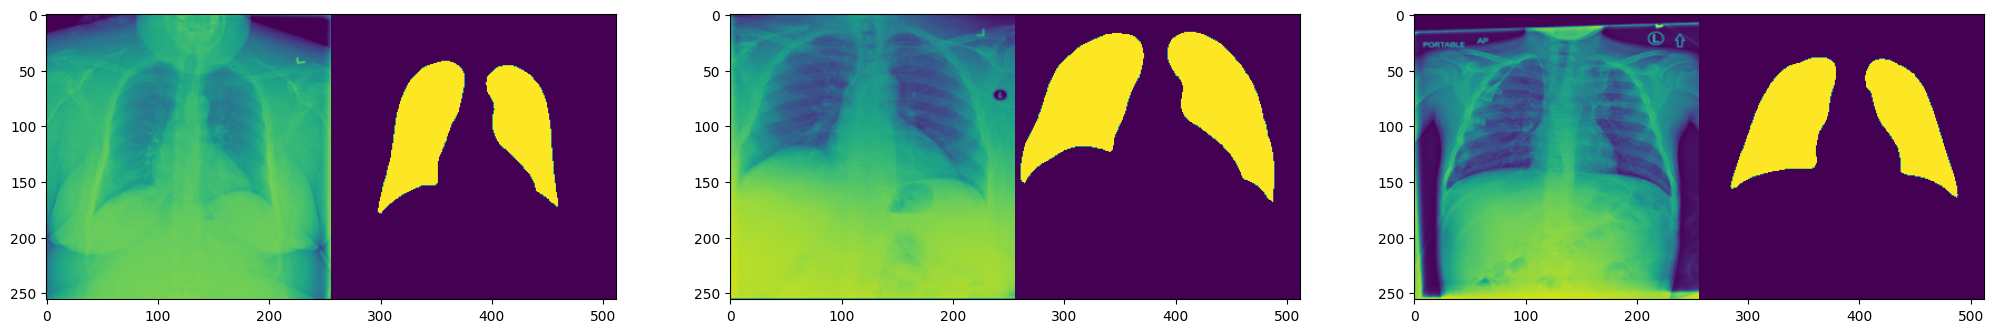

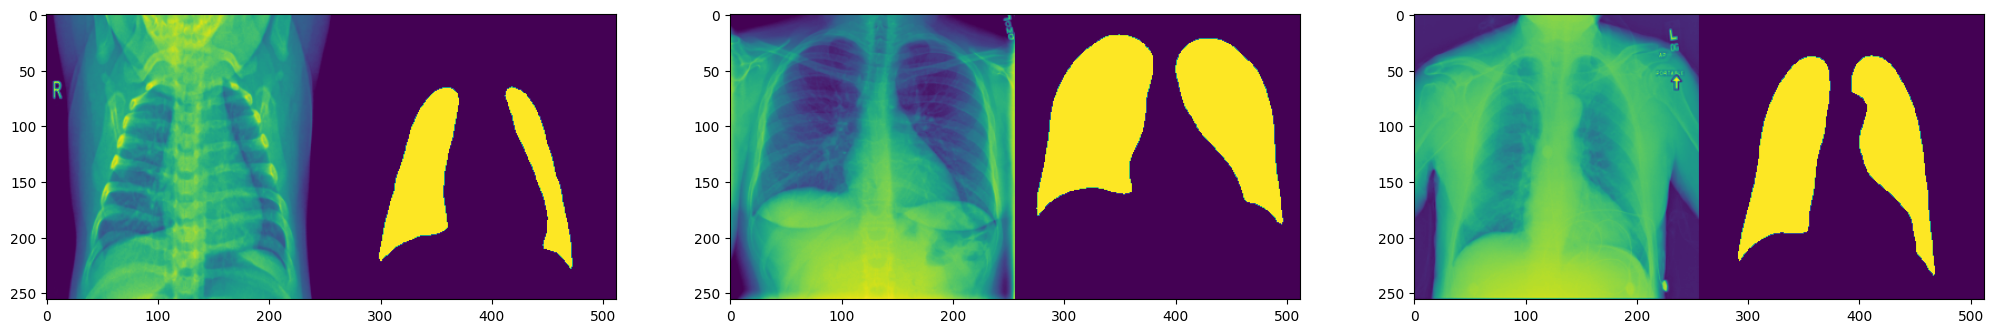

dataset size : images (8690, 256, 256, 1) masks (8690, 256, 256, 1)


In [4]:
# Importing data
dim = 256
images, masks = getData(dim,N=size_max_cat)

print("visualize dataset")
plotMask(images, masks)


print("dataset size : images", images.shape, "masks", masks.shape)


In [5]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(dim,dim,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [6]:

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', min_delta=0.001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min",
                      min_delta=0.0001,
                      patience=5)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [7]:

model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(lr=0.0001), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

c:\Users\Inrae\anaconda3\envs\tensor_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

train_vol, valid_vol, train_seg, valid_seg = train_test_split((images-127)/127, 
                                                             (masks>127).astype(np.float32),
                                                             test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

datagen = ImageDataGenerator() 

# Augmenter respectivement les jeu de données d'entrainement
train_dataset = datagen.flow(train_vol, train_seg, batch_size = batch_size)

test_dataset = datagen.flow(test_vol, test_seg, batch_size = batch_size)

val_dataset = datagen.flow(valid_vol, valid_seg, batch_size = batch_size)


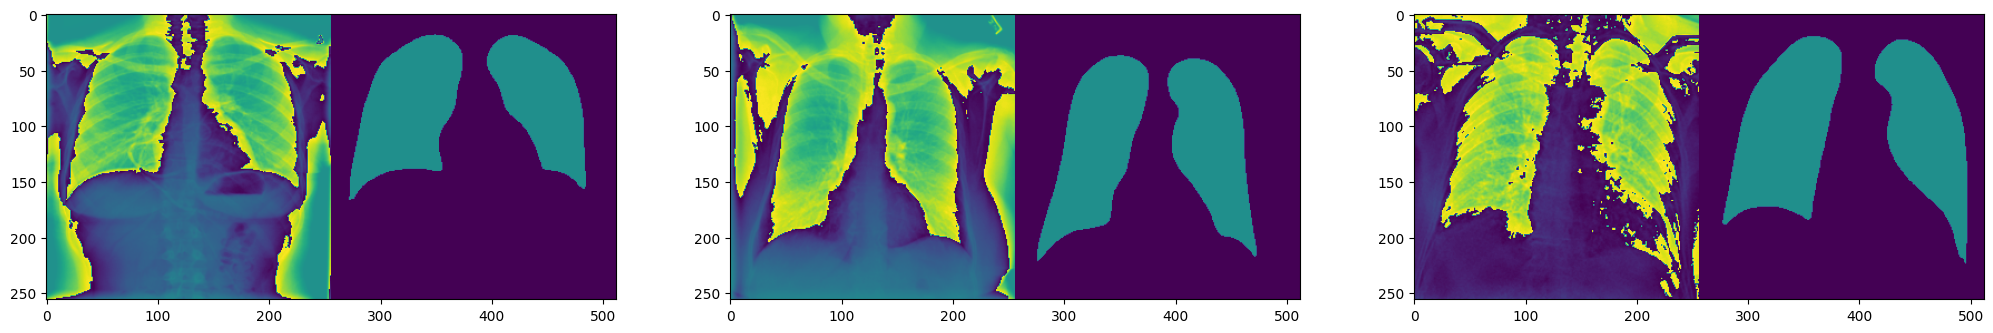

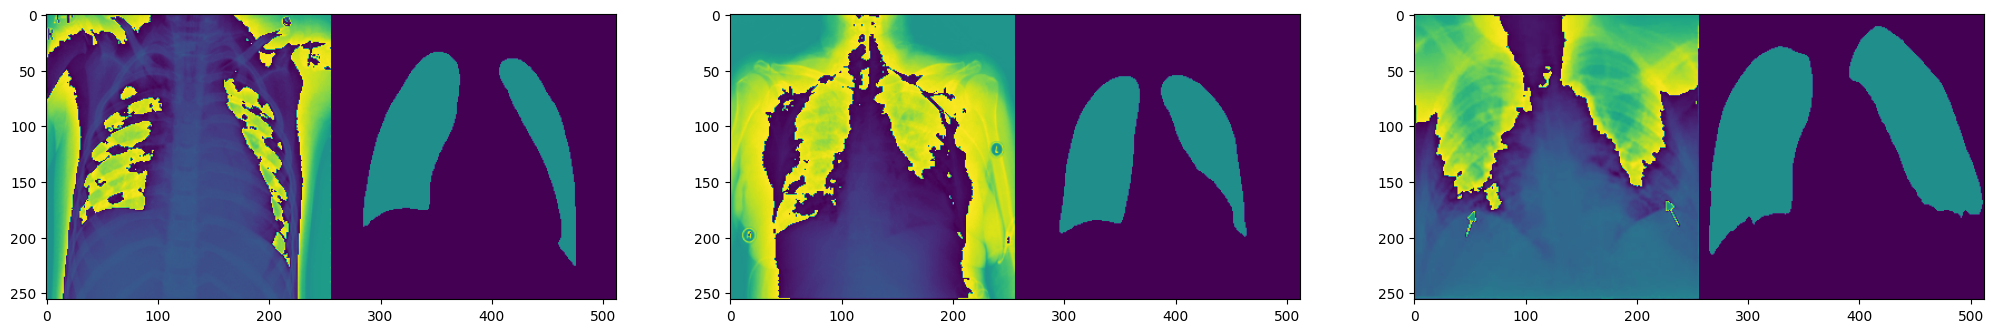

In [39]:
# Obtenir un batch d'images
dataiter = iter(train_dataset)
image, mask = next(dataiter)
plotMask(image, mask)

In [40]:
del loss_history
import gc
clear_output()
gc.collect()
tf.keras.backend.clear_session()

loss_history = model.fit(train_dataset,
                         batch_size = batch_size,
                  epochs = 50,
                  validation_data = test_dataset,
                  callbacks=callbacks_list)

Epoch 1/50
880/880 [==============================] - ETA: 0s - loss: -0.7948 - dice_coef: 0.7948 - binary_accuracy: 0.8556
Epoch 1: val_loss improved from inf to -0.90455, saving model to cxr_reg_weights.best.hdf5
880/880 [==============================] - 198s 224ms/step - loss: -0.7948 - dice_coef: 0.7948 - binary_accuracy: 0.8556 - val_loss: -0.9046 - val_dice_coef: 0.9046 - val_binary_accuracy: 0.9543 - lr: 1.0000e-04
Epoch 2/50
880/880 [==============================] - ETA: 0s - loss: -0.9306 - dice_coef: 0.9306 - binary_accuracy: 0.9677
Epoch 2: val_loss improved from -0.90455 to -0.94638, saving model to cxr_reg_weights.best.hdf5
880/880 [==============================] - 193s 219ms/step - loss: -0.9306 - dice_coef: 0.9306 - binary_accuracy: 0.9677 - val_loss: -0.9464 - val_dice_coef: 0.9463 - val_binary_accuracy: 0.9754 - lr: 1.0000e-04
Epoch 3/50
880/880 [==============================] - ETA: 0s - loss: -0.9476 - dice_coef: 0.9476 - binary_accuracy: 0.9756
Epoch 3: val_loss

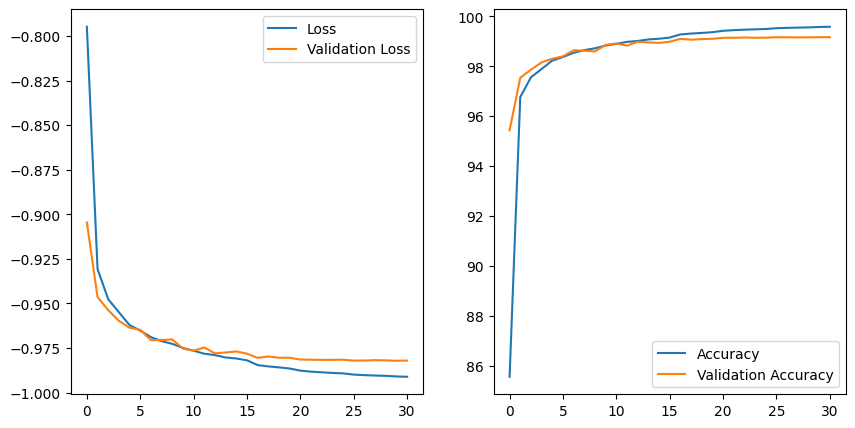

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [13]:
#model.load_weights("cxr_reg_weights.best.hdf5")


# A améliorer avec plus de donnees
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

def test_accuracy(model, X, y):
    X_test, y_test = X, y
    batch_size = 8
    predictions = model.predict(X_test, batch_size=batch_size)

    # Reshape predictions if necessary (assuming single-channel masks)
    y_pred = np.squeeze(predictions)
    y_pred = np.expand_dims(y_pred, axis=-1)

    threshold = 0.5
    y_pred_binary = (y_pred >= threshold).astype(int)

    # Calculate pixel-wise accuracy
    accuracy = np.mean(y_pred_binary == y_test)

    dice_coefficient_score = dice_coefficient(y_test, y_pred)
    dice_loss_score = dice_loss(y_test, y_pred)
    print(f"Sample size: {y_test.shape}")
    print(f"Pixel-wise Accuracy: {accuracy:.4f}")
    print(f'Dice Coefficient: {dice_coefficient_score:.4f}')
    print(f'Dice Loss: {dice_loss_score:.4f}')
    X_test,y_test = 0,0

print("jeu de données d'entrainement")
test_accuracy(model, train_vol[:1000], train_seg[:1000])

print("jeu de données de paramétrage")
test_accuracy(model, test_vol, test_seg)

print("jeu de données de validation")
test_accuracy(model, valid_vol, valid_seg)

jeu de données d'entrainement
Sample size: (1000, 256, 256, 1)
Pixel-wise Accuracy: 0.9958
Dice Coefficient: 0.9911
Dice Loss: 0.0089
jeu de données de paramétrage
Sample size: (783, 256, 256, 1)
Pixel-wise Accuracy: 0.9917
Dice Coefficient: 0.9822
Dice Loss: 0.0178
jeu de données de validation
Sample size: (869, 256, 256, 1)
Pixel-wise Accuracy: 0.9918
Dice Coefficient: 0.9822
Dice Loss: 0.0178


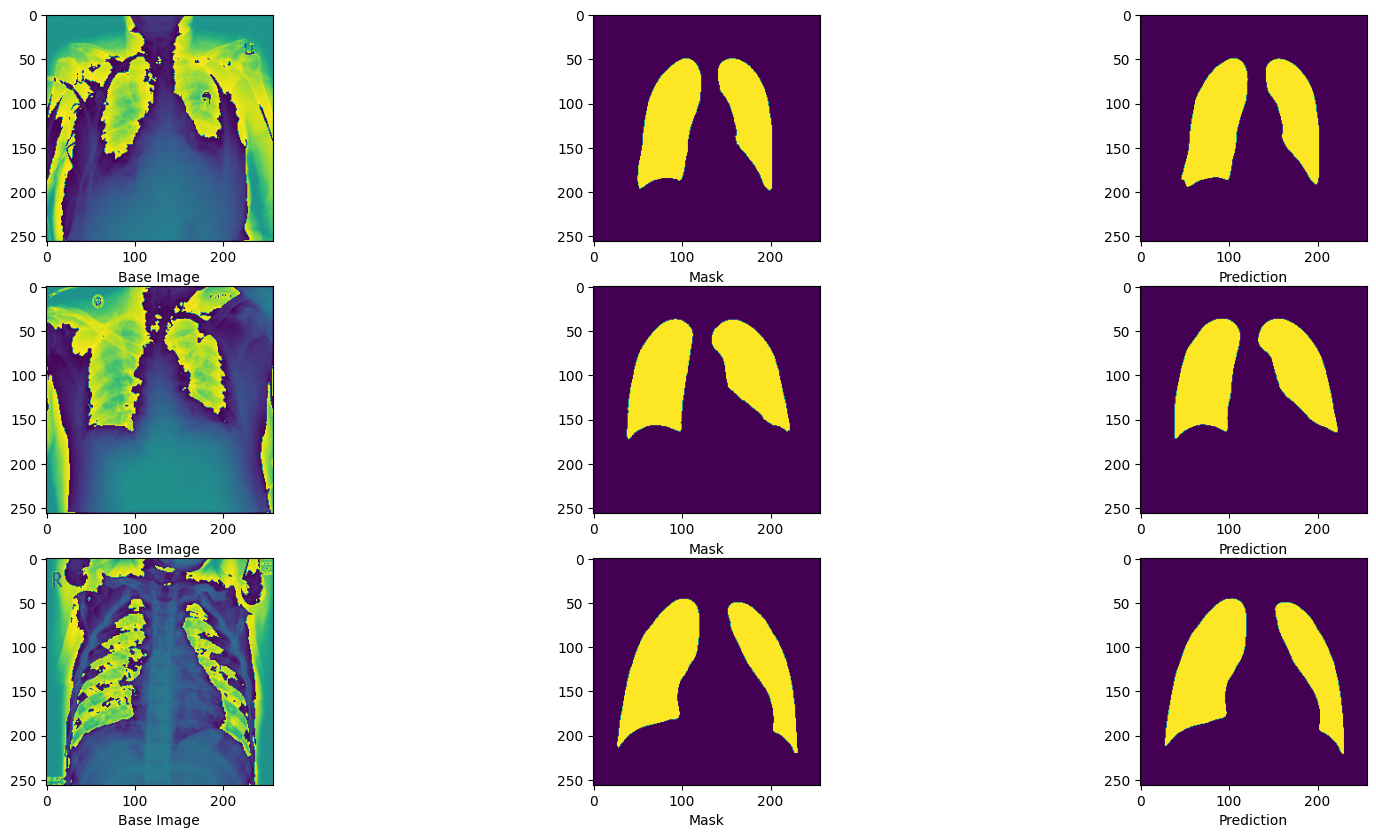

In [14]:
# Obtenir un batch d'images
dataiter = iter(val_dataset)
image, mask = next(dataiter)

preds = model.predict(image)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i])
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(mask[i])
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(preds[i])
    plt.xlabel("Prediction")
